Initial DataFrame Shape: (1000, 21)
--------------------------------------------------
Current DataFrame Columns (after initial cleaning):
['checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_commitment', 'personal_status', 'other_parties', 'residence_since', 'property_magnitude', 'age', 'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker', 'class']
--------------------------------------------------
Columns dropped: ['other_parties', 'other_payment_plans', 'own_telephone']
New DataFrame Shape: (1000, 18)
--------------------------------------------------
Apostrophes removed from values in all string columns.
--------------------------------------------------
Checking status categories updated.
--------------------------------------------------
Savings status categories updated.
--------------------------------------------------
Class column values updated to

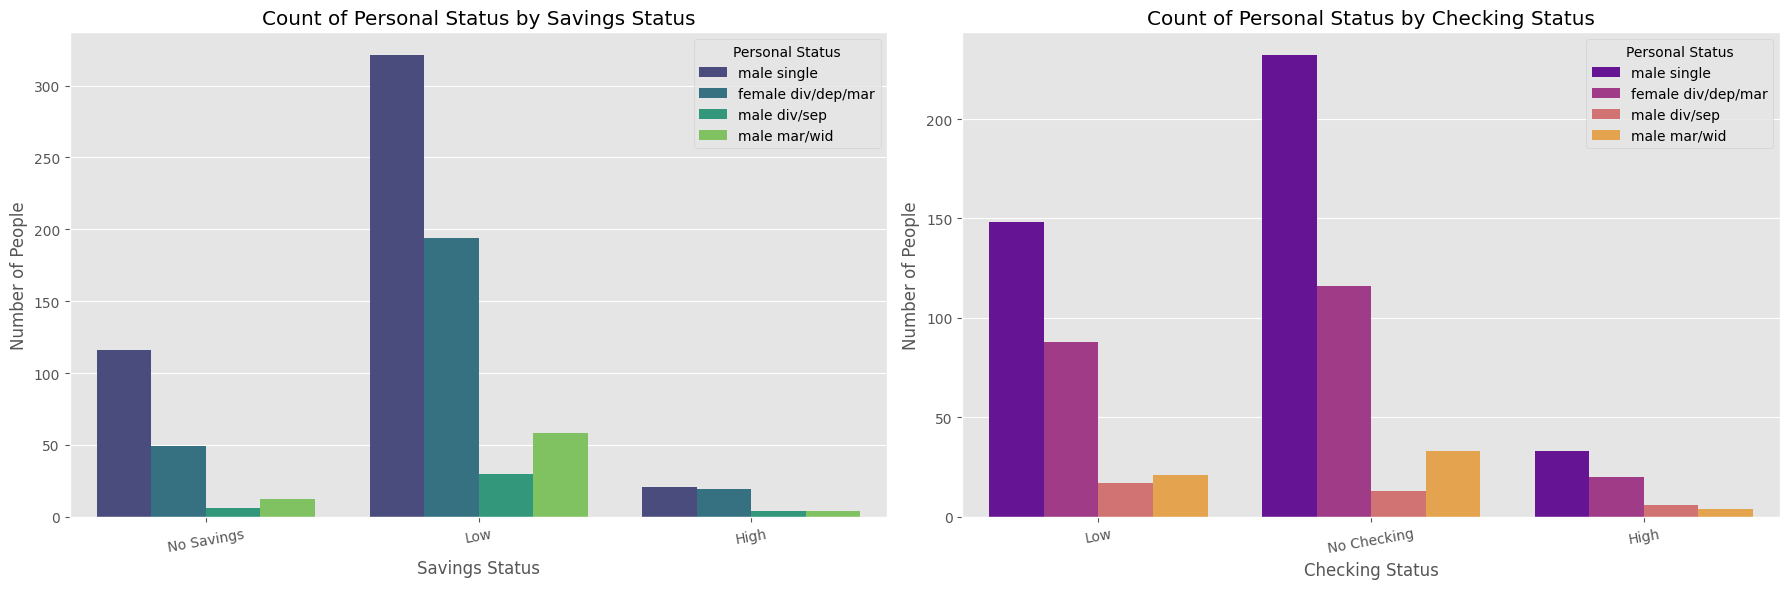

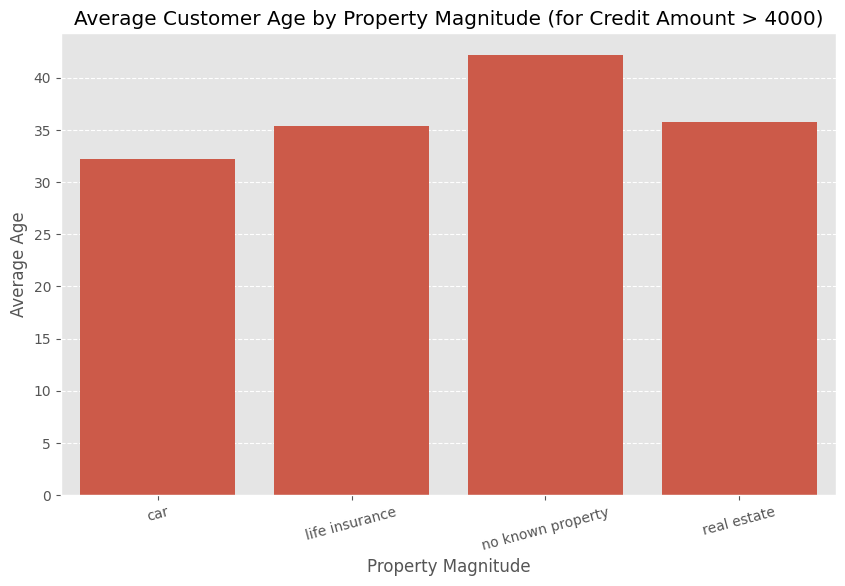

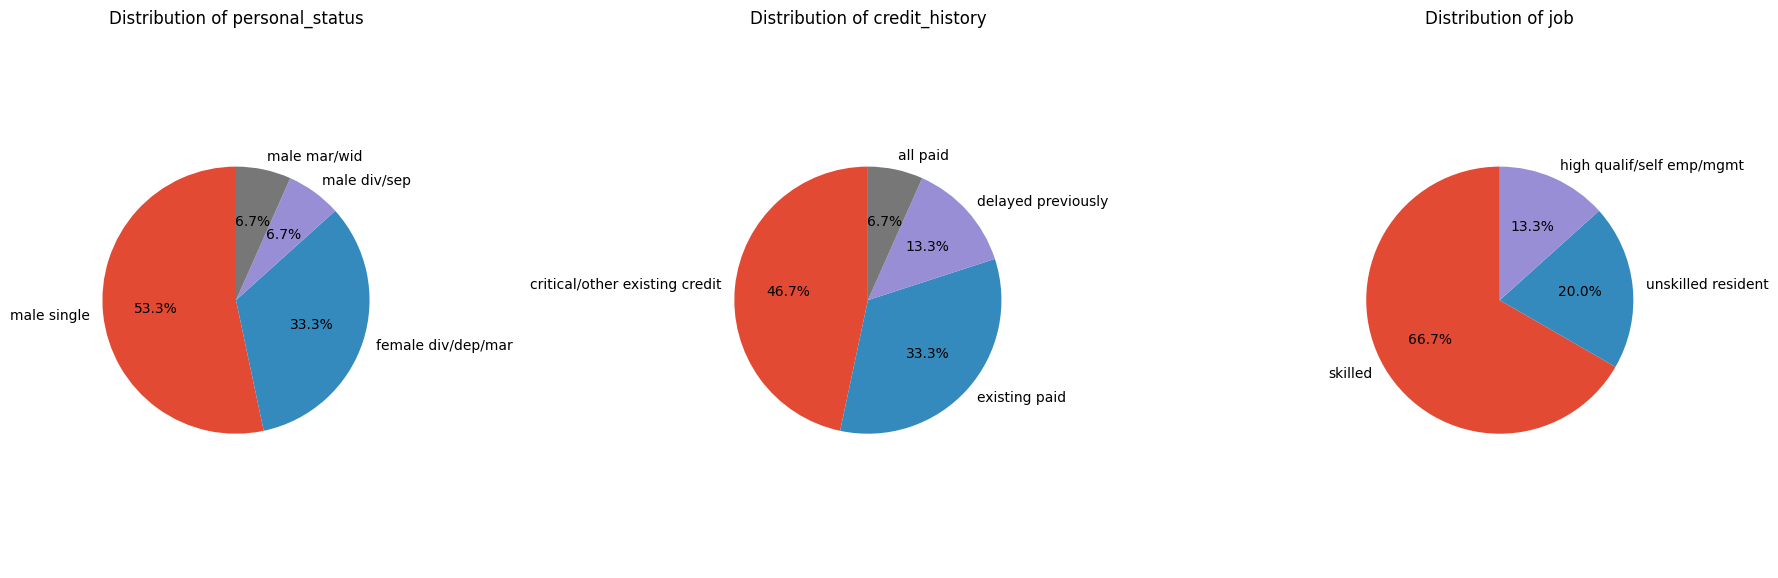

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#FIX: Set Pandas option to explicitly adopt future downcasting behavior,
# which eliminates the FutureWarning about 'df['class'] = df['class'].replace(class_mapping).astype(int)'
pd.set_option('future.no_silent_downcasting', True) 

# Set a style for visualizations
plt.style.use('ggplot')

## 💻 Problem 2: German Credit Dataset (70 points)

# Load the dataset
df = pd.read_csv('GermanCredit.csv')

# --- Robust Column Name Cleaning ---
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace("'", "")

print(f"Initial DataFrame Shape: {df.shape}")
print("-" * 50)

# ⚠️ CRITICAL DEBUGGING STEP: Output current column names
print("Current DataFrame Columns (after initial cleaning):")
print(list(df.columns))
print("-" * 50)


# ---
## Preprocessing (29 pts)

### [8 pts] Drop the 3 columns that contribute the least to the dataset. These would be the columns with the highest number of non-zero 'none' values. Break ties by going left to right in columns.

def drop_n_least_contributing_columns(data, n=3):
    """Drops the n columns with the highest count of non-zero 'none' values."""
    none_counts = {}
    for col in data.columns:
        if data[col].dtype == 'object':
            count = (data[col].astype(str).str.lower() == 'none').sum()
            if count > 0:
                none_counts[col] = count

    none_series = pd.Series(none_counts).sort_values(ascending=False)
    columns_to_drop = none_series.index[:n].tolist()

    df_dropped = data.drop(columns=columns_to_drop, inplace=False)
    
    print(f"Columns dropped: {columns_to_drop}")
    print(f"New DataFrame Shape: {df_dropped.shape}")
    
    return df_dropped

df = drop_n_least_contributing_columns(df, n=3)
print("-" * 50)


### [4 pts] Certain values in some of the columns contain unnecessary apostrophes (‘). Remove the apostrophes.

string_cols = df.select_dtypes(include='object').columns

df[string_cols] = df[string_cols].apply(
    lambda col: col.str.replace("'", "", regex=False)
)

print("Apostrophes removed from values in all string columns.")
print("-" * 50)


### [5 pts] The checking_status column has values in 4 categories: 'no checking', '<0', '0<=X<200', and '>=200'. Change these to 'No Checking', 'Low', 'Medium', and 'High' respectively.

checking_status_mapping = {
    'no checking': 'No Checking',
    '<0': 'Low',
    '0<=x<200': 'Medium',
    '>=200': 'High'
}

df['checking_status'] = df['checking_status'].map(checking_status_mapping)
print("Checking status categories updated.")
print("-" * 50)


### [5 pts] The savings_status column has values in 4 categories: 'no known savings', '<100', '100<=X<500', '500<=X<1000', and '>=1000'. Change these to 'No Savings', 'Low', 'Medium', 'High', and 'High' respectively.

savings_status_mapping = {
    'no known savings': 'No Savings',
    '<100': 'Low',
    '100<=x<500': 'Medium',
    '500<=x<1000': 'High',
    '>=1000': 'High'
}

df['savings_status'] = df['savings_status'].map(savings_status_mapping)
print("Savings status categories updated.")
print("-" * 50)


### [3 pts] Change class column values from 'good' to '1' and 'bad' to '0'.

class_mapping = {
    'good': 1,
    'bad': 0
}

df['class'] = df['class'].replace(class_mapping).astype(int)
print("Class column values updated to 1 (good) and 0 (bad).")
print("-" * 50)


### [4 pts] Change the employment column value 'unemployed' to 'Unemployed', and for the others, change to 'Amateur', 'Professional', 'Experienced' and 'Expert', depending on year range.

employment_mapping = {
    'unemployed': 'Unemployed',
    '<1': 'Amateur',
    '1<=x<4': 'Professional',
    '4<=x<7': 'Experienced',
    '>=7': 'Expert'
}

df['employment'] = df['employment'].replace(employment_mapping)
print("Employment categories updated.")
print("-" * 50)


# ---
## Analysis (17 pts)

### [5 pts] Often we need to find correlations between categorical attributes... Do this for the following two counts.

#### [3 pts] Get the count of each category of foreign workers (yes and no) for each class of credit (good and bad).

cross_tab_foreign_worker_class = pd.crosstab(
    df['foreign_worker'], 
    df['class'], 
    margins=True, 
    margins_name='Total'
)

print("Count of foreign_worker categories for each class (1=Good, 0=Bad):")
print(cross_tab_foreign_worker_class)
print("-" * 50)


#### [2 pts] Similarly, get the count of each category of employment for each category of saving_status.

cross_tab_employment_savings = pd.crosstab(
    df['employment'], 
    df['savings_status'], 
    margins=True, 
    margins_name='Total'
)

print("Count of employment categories for each saving_status category:")
print(cross_tab_employment_savings)
print("-" * 50)


### [4 pts] Find the average credit_amount of single males that have 4<=X<7 years of employment. You can leave the raw result as is, no need for rounding.

filtered_df = df[
    (df['personal_status'] == 'male single') & 
    (df['employment'] == 'Experienced')
]

average_credit_amount = filtered_df['credit_amount'].mean()

print(f"Average credit_amount for single males with 'Experienced' employment: \n{average_credit_amount}")
print("-" * 50)


### [4 pts] Find the average credit duration for each of the job types. You can leave the raw result as is, no need for rounding.

# FINAL FIX: Uses 'duration' as the column name, with an attempt at 'duration_in_month' as fallback.
try:
    average_duration_by_job = df.groupby('job')['duration'].mean()
except KeyError:
    try:
        average_duration_by_job = df.groupby('job')['duration_in_month'].mean()
    except KeyError:
        print("ERROR: Neither 'duration' nor 'duration_in_month' found. Please check your columns.")
        average_duration_by_job = pd.Series(["Column not found"], index=["Error"])

print("Average credit duration (in months) for each job type:")
print(average_duration_by_job)
print("-" * 50)


### [4 pts] For the purpose 'education', what is the most common checking_status and savings_status?

education_df = df[df['purpose'] == 'education']

most_common_checking = education_df['checking_status'].mode()[0]
most_common_savings = education_df['savings_status'].mode()[0]

print(f"For the purpose 'education':")
print(f"    Most common checking status: {most_common_checking}")
print(f"    Most common savings status: {most_common_savings}")
print("-" * 50)


# ---
## Visualization (24 pts)

### [9 pts] Plot subplots of two bar charts: one for savings_status (x-axis) to personal status (y-axis), and another for checking_status (x-axis) to personal_status (y-axis). In each of the charts, each personal status category bar (number of people in that category) should be of a different color.

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Chart 1: savings_status vs. personal_status
sns.countplot(
    data=df,
    x='savings_status',
    hue='personal_status',
    ax=axes[0],
    palette='viridis'
)
axes[0].set_title('Count of Personal Status by Savings Status')
axes[0].set_xlabel('Savings Status')
axes[0].set_ylabel('Number of People')
axes[0].tick_params(axis='x', rotation=10)
axes[0].legend(title='Personal Status', loc='upper right')

# Chart 2: checking_status vs. personal_status
sns.countplot(
    data=df,
    x='checking_status',
    hue='personal_status',
    ax=axes[1],
    palette='plasma'
)
axes[1].set_title('Count of Personal Status by Checking Status')
axes[1].set_xlabel('Checking Status')
axes[1].set_ylabel('Number of People')
axes[1].tick_params(axis='x', rotation=10)
axes[1].legend(title='Personal Status', loc='upper right')

plt.tight_layout()


### [9 pts] For people having credit_amount more than 4000, plot a bar graph which maps property_magnitude (x-axis) to the average customer age for that magnitude (y-axis).

high_credit_df = df[df['credit_amount'] > 4000].copy()
avg_age_by_property = high_credit_df.groupby('property_magnitude')['age'].mean().reset_index()

plt.figure(figsize=(10, 6))
# ⭐ BEST FIX: Removed 'palette' argument from barplot without 'hue' to prevent Seaborn warning
sns.barplot(
    data=avg_age_by_property,
    x='property_magnitude',
    y='age'
)

plt.title('Average Customer Age by Property Magnitude (for Credit Amount > 4000)')
plt.xlabel('Property Magnitude')
plt.ylabel('Average Age')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--')
plt.show()


### [6 pts] For people with a "High" savings_status and age above 40, use subplots to plot the following pie charts: Personal status, Credit history, Job

filtered_for_pie = df[
    (df['savings_status'] == 'High') & 
    (df['age'] > 40)
].copy()

pie_columns = ['personal_status', 'credit_history', 'job']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.style.use('fivethirtyeight')

for i, col in enumerate(pie_columns):
    counts = filtered_for_pie[col].value_counts()
    
    axes[i].pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 10}
    )
    axes[i].set_title(f'Distribution of {col}', fontsize=12)
    axes[i].axis('equal')

plt.tight_layout()